In [1]:
#!pip install pyswarms

Import packages

In [1]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.Optimization import SavantPSO
import numpy as np

# Read In

Import the config file and set the config dict. set some variables from the config dict

In [2]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/config ups us reg.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
optimization_start_date = config_dict['PROPHETSETTING']['optimization_start_date']
optimization_end_date = config_dict['PROPHETSETTING']['optimization_end_date']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

# Read data

Read the cuts df, hyper parameter table 

In [3]:

cuts_df = pd.read_csv(base_path+'New_Cuts_df.csv', index_col=0) # read the new_cuts_df.csv file 
cuts_df = cuts_df.reset_index(drop = True) # reset index 

# create a variable with the name of the pickle file
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' 
cuts_df['periods'] = periods # create the variable with the number of periods to forecast
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,forecaster_name_list
0,US,Google AdWords,Competitor,183,0.001,0.01,10.00,multiplicative,additive,na,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Google AdWords Competitor.pkl
1,US,Google AdWords,Generic,183,0.100,1.00,10.00,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Google AdWords Generic.pkl
2,US,Google AdWords,Brand,183,0.100,10.00,0.01,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Google AdWords Brand.pkl
3,US,Bing Ads,Competitor,183,0.001,0.01,10.00,multiplicative,multiplicative,na,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Bing Ads Competitor.pkl
4,US,Bing Ads,Generic,183,0.100,10.00,0.01,additive,additive,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Bing Ads Generic.pkl
5,US,Bing Ads,Brand,183,0.050,0.01,0.01,additive,multiplicative,multiplicative,...,na,na,na,na,na,na,logistic,251.0,2024-04-25,US Bing Ads Brand.pkl


get the list of pickle files 

In [4]:
# get model list
forecasters_array = cuts_df.forecaster_name_list
forecasters_array

0    US Google AdWords Competitor.pkl
1       US Google AdWords Generic.pkl
2         US Google AdWords Brand.pkl
3          US Bing Ads Competitor.pkl
4             US Bing Ads Generic.pkl
5               US Bing Ads Brand.pkl
Name: forecaster_name_list, dtype: object

import the analytical file 

In [5]:
# Get analytical file
analytical_file = pd.read_csv(analytical_file_path).drop('Unnamed: 0', axis = 1) # read the analytical file .csv 
analytical_file['ds'] = pd.to_datetime(analytical_file['ds']) # ensure the date variable is in the correct datetime type
analytical_file_check_version = analytical_file.copy() # generate a copy 
analytical_file_check_version


,region,market,account_type,funnel,ds,X,Month,Year,US_Bing_Ads_Brand_Apr_2024,US_Bing_Ads_Brand_Aug_2024,...,US_Google_AdWords_Generic_Dec_2024,US_Google_AdWords_Generic_Jul_2024,US_Google_AdWords_Generic_Jun_2024,US_Google_AdWords_Generic_May_2024,US_Google_AdWords_Generic_Nov_2024,US_Google_AdWords_Generic_Oct_2024,US_Google_AdWords_Generic_Sep_2024,Weekend,AOV,ROAS
0,US,US,Bing Ads,Brand,2024-04-25,3599.730000,Apr,2024,3599.73,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
1,US,US,Bing Ads,Brand,2024-04-26,3307.800000,Apr,2024,3307.80,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
2,US,US,Bing Ads,Brand,2024-04-27,957.140000,Apr,2024,957.14,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
3,US,US,Bing Ads,Brand,2024-04-28,917.390000,Apr,2024,917.39,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
4,US,US,Bing Ads,Brand,2024-04-29,4319.260000,Apr,2024,4319.26,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,34.95,35.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,US,US,Google AdWords,Generic,2024-12-27,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1502,US,US,Google AdWords,Generic,2024-12-28,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1503,US,US,Google AdWords,Generic,2024-12-29,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1504,US,US,Google AdWords,Generic,2024-12-30,70.920000,Dec,2024,0.00,0.0,...,70.920000,0.0,0.0,0.0,0.0,0.0,0.0,0,43.94,5.99


import the constraint file 

In [6]:
# Get constrain file
constraint_file = pd.read_csv(constraint_file_name) # read the constraint file .csv
constraint_file['init'] = constraint_file[['MinWeight', 'MaxWeight']].mean(axis = 1) #create a variable with the initial wheights the mean between the min weight and the max weight
constraint_file

,market,account_type,funnel,Month,Year,variable_splits,Constrain_Variable_Name,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,...,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,MinWeight,MaxWeight,init
0,US,Bing Ads,Brand,Apr,2024,US_Bing_Ads_Brand_Apr_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
1,US,Bing Ads,Brand,May,2024,US_Bing_Ads_Brand_May_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
2,US,Bing Ads,Brand,Jun,2024,US_Bing_Ads_Brand_Jun_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
3,US,Bing Ads,Brand,Jul,2024,US_Bing_Ads_Brand_Jul_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
4,US,Bing Ads,Brand,Aug,2024,US_Bing_Ads_Brand_Aug_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
5,US,Bing Ads,Brand,Sep,2024,US_Bing_Ads_Brand_Sep_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
6,US,Bing Ads,Brand,Oct,2024,US_Bing_Ads_Brand_Oct_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
7,US,Bing Ads,Brand,Nov,2024,US_Bing_Ads_Brand_Nov_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.55,0.750000,0.650000
8,US,Bing Ads,Brand,Dec,2024,US_Bing_Ads_Brand_Dec_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
9,US,Bing Ads,Competitor,Apr,2024,US_Bing_Ads_Competitor_Apr_2024,cost,183,0.001,0.01,...,na,na,na,na,linear,251.0,2024-04-25,0.80,1.200000,1.000000


# PSO Function

Initialize the SavantPSO class function with the cuts, analytical and constraint file, also include the config dict

In [13]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)

Set the PSO hyper parameters 

In [15]:
itNum = 100
n_particles = 0
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}

optimize the budget allocation setting optimized input weights that maximize conversion quantity. <br>
    run_pso method of SavantPSO class function, with PSO hyper parameters

In [16]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum)

2024-05-08 03:34:49,676 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Input Weight History 05.08.2024.csv


pyswarms.single.global_best:   0%|          |0/10

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3144092.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0


pyswarms.single.global_best:   0%|          |0/10


KeyboardInterrupt: 

Save the PSO optimization results and plot the cost through the different iterations

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Pos Result 05.07.2024.csv
File generated
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Iteration History 05.07.2024.csv
File exists. Please delete it first.


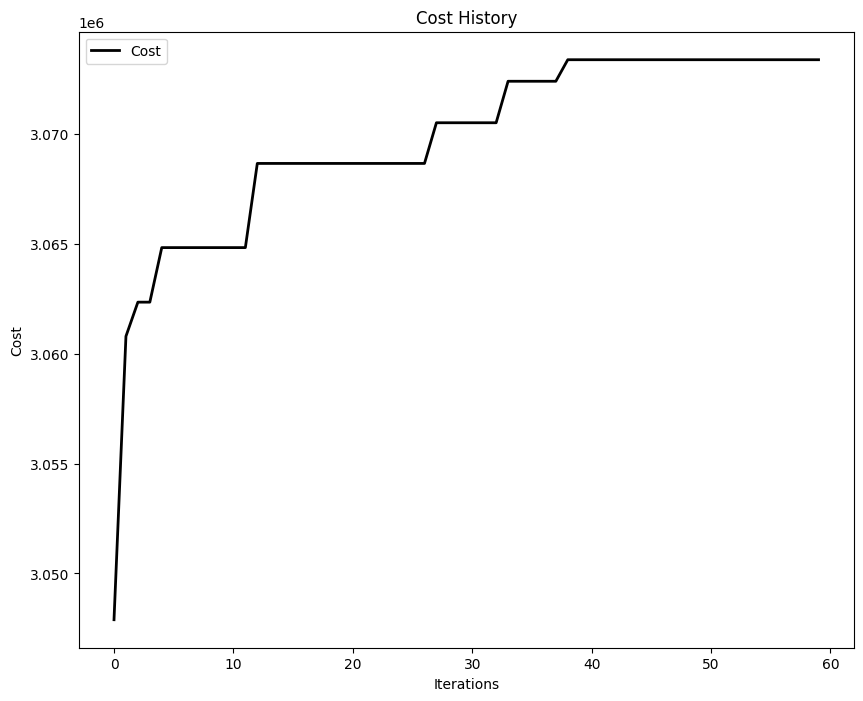

In [12]:
resultPSO.SaveResult(result)

#### if PSO optimization has already being run and we have some inititial input wehights

Read initial position input weights 

In [ ]:
pso_date = '01.21.2024' #datetime.date.today().strftime("%m.%d.%Y")# 
fileName = base_path + f'Pos Result {pso_date}.csv' 
pos_df = pd.read_csv(fileName).drop('Unnamed: 0', axis = 1) # read the pso result file to get the input weights
inputWeights =np.tile(pos_df.pos.to_numpy(), [n_particles, 1]) # create the input weights parameters


2024-04-18 03:50:53,381 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/All Regions/us/test of Juan/Input Weight History 04.18.2024.csv


pyswarms.single.global_best:   0%|          |0/50

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---

pyswarms.single.global_best:   2%|▏         |1/50, best_cost=-6.27e+5

yhat: -627223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625920.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627965.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625439.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626073.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:   4%|▍         |2/50, best_cost=-6.31e+5

yhat: -627154.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626487.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -623671.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -624474.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629433.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:   6%|▌         |3/50, best_cost=-6.31e+5

yhat: -630077.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629344.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626405.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628313.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628924.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:   8%|▊         |4/50, best_cost=-6.31e+5

yhat: -626927.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628829.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626748.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629914.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624549.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  10%|█         |5/50, best_cost=-6.31e+5

yhat: -627154.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630852.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626746.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626083.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625418.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=-6.31e+5

yhat: -626722.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -623639.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -623052.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627056.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626796.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=-6.31e+5

yhat: -629140.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626319.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -622788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625213.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626104.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=-6.31e+5

yhat: -629212.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -628051.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625724.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626229.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -628617.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=-6.31e+5

yhat: -627540.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628462.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627599.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -622111.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625669.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  20%|██        |10/50, best_cost=-6.31e+5

yhat: -629989.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626745.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628481.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626624.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627228.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=-6.31e+5

yhat: -626803.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628886.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626028.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -624266.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626573.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=-6.31e+5

yhat: -627614.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626408.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625375.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624686.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630763.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=-6.31e+5

yhat: -626559.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625624.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626390.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627455.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626342.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=-6.31e+5

yhat: -625883.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627379.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630715.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627035.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629192.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  30%|███       |15/50, best_cost=-6.31e+5

yhat: -627953.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626903.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628339.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625526.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627436.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  32%|███▏      |16/50, best_cost=-6.31e+5

yhat: -628118.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -625339.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629450.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -623863.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629127.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=-6.31e+5

yhat: -629368.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628178.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626386.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628577.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627140.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=-6.31e+5

yhat: -626619.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630252.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629258.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626117.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626858.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=-6.31e+5

yhat: -626979.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -624304.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -624764.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629082.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629092.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  40%|████      |20/50, best_cost=-6.31e+5

yhat: -628330.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626948.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628241.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -628945.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629572.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=-6.31e+5

yhat: -628964.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630872.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627835.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629550.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -631234.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=-6.31e+5

yhat: -628586.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624967.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628754.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626682.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628394.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=-6.31e+5

yhat: -627286.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628603.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629973.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630824.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630155.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=-6.31e+5

yhat: -627847.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625240.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626815.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628082.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -631591.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  50%|█████     |25/50, best_cost=-6.32e+5

yhat: -627947.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -624758.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629990.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629715.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628672.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=-6.32e+5

yhat: -626943.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626427.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629198.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626641.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=-6.32e+5

yhat: -627281.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628326.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624114.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629125.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628518.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=-6.32e+5

yhat: -628668.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627255.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627826.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628351.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625039.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=-6.32e+5

yhat: -629093.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628582.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627452.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628569.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627913.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  60%|██████    |30/50, best_cost=-6.32e+5

yhat: -627806.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630866.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -629269.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630303.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=-6.32e+5

yhat: -629590.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627721.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -623840.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628217.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627770.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  64%|██████▍   |32/50, best_cost=-6.32e+5

yhat: -628410.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628371.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -625642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630273.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627407.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  66%|██████▌   |33/50, best_cost=-6.32e+5

yhat: -625861.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627575.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629456.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627069.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -630312.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  68%|██████▊   |34/50, best_cost=-6.32e+5

yhat: -627795.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628164.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626075.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627134.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628290.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  70%|███████   |35/50, best_cost=-6.32e+5

yhat: -628966.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628105.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626586.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629574.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627849.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  72%|███████▏  |36/50, best_cost=-6.32e+5

yhat: -629109.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627406.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628420.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628108.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627926.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=-6.32e+5

yhat: -627804.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627624.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624312.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626703.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627651.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=-6.32e+5

yhat: -630187.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626612.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628126.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629159.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627180.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=-6.32e+5

yhat: -627556.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626158.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -621973.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628175.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627750.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  80%|████████  |40/50, best_cost=-6.32e+5

yhat: -626307.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629391.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626906.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -628122.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628477.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=-6.32e+5

yhat: -628035.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -623802.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629502.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629101.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627956.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=-6.32e+5

yhat: -627669.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627819.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628205.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629032.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=-6.32e+5

yhat: -629925.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627817.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628554.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628425.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628732.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=-6.32e+5

yhat: -626837.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626965.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626328.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -630519.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626142.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=-6.32e+5

yhat: -626542.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627224.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -626883.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627548.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629293.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=-6.32e+5

yhat: -628787.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629312.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630167.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -628323.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626752.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=-6.32e+5

yhat: -628258.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624890.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -624394.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630209.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -627433.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=-6.32e+5

yhat: -629150.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  -0.0
yhat: -628904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626296.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -627112.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -625284.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=-6.32e+5

yhat: -627822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -630134.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -626944.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629498.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  1107066.0 difference between planned and forecast X:  0.0
yhat: -629088.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-6.32e+5
2024-04-18 05:26:34,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -631591.0, best pos: [0.94147144 1.13235445 0.90735946 1.12861693 1.0601695  1.05763392
 1.18663699 1.14510455 0.99752745 0.80679573 1.01964194 0.86363084]


yhat: -628250.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 5740.795632123947


run_pso method of SavantPSO class function, with PSO hyper parameters and input weights as initial position

In [ ]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum , init_pos=inputWeights)


if needed cave the PSO optimization results and plot the cost through the different iterations 

In [ ]:
resultPSO.SaveResult(result)